In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load the dataset
df = pd.read_csv("../data/dataset.csv", encoding="ISO-8859-1", low_memory=False)

In [4]:

# Display basic info
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null

In [5]:
# Handling missing values (example: forward fill, drop columns with too many NaNs)
df.fillna(method='ffill', inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_20756\547248588.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [6]:
# Convert date column to datetime format if applicable
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [7]:
# Extract year, month, and day for temporal analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()

In [19]:
print(df["year"])

0         1990
1         1990
2         1990
3         1990
4         1990
          ... 
435737    2015
435738    2015
435739    2015
435740    2015
435741    2015
Name: year, Length: 435742, dtype: int32


In [9]:
# CPCB AQI Calculation using all major pollutants
def calculate_aqi(row):
    breakpoints = {
        'pm2_5': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400)],
        'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400)],
        'no2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300), (281, 400, 301, 400)],
        'so2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), (381, 800, 201, 300), (801, 1600, 301, 400)],
        'co': [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), (10.1, 17, 201, 300), (17.1, 34, 301, 400)],
        'o3': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), (169, 208, 201, 300), (209, 748, 301, 400)]
    }
    
    sub_indices = []
    for pollutant, bps in breakpoints.items():
        if pollutant in row:
            value = row[pollutant]
            for c_low, c_high, i_low, i_high in bps:
                if c_low <= value <= c_high:
                    sub_index = ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
                    sub_indices.append(sub_index)
                    break
    
    return max(sub_indices) if sub_indices else np.nan
# Apply AQI calculation to dataset
df['AQI'] =df.apply(calculate_aqi, axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_20756\2783470769.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='year', y='AQI', data=df, estimator='mean', ci=None)


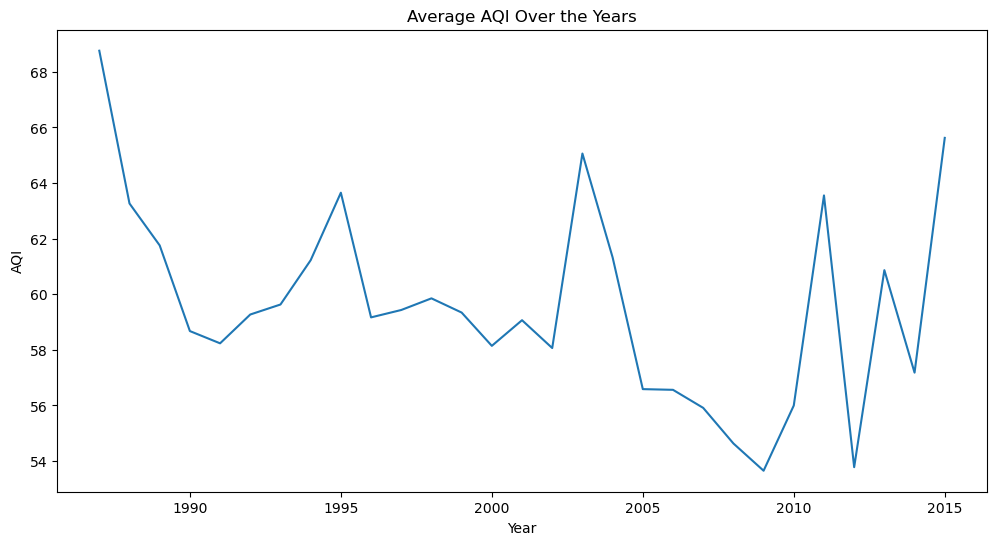

In [10]:
# --- 1. AQI Trends Over Time ---
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='AQI', data=df, estimator='mean', ci=None)
plt.title('Average AQI Over the Years')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.show()

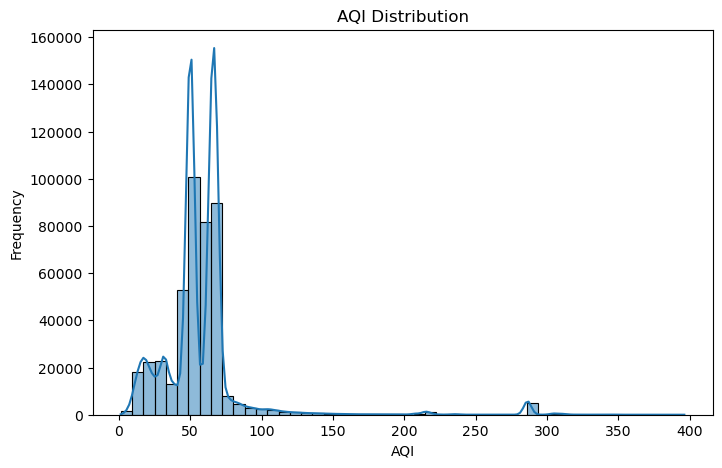

In [11]:
# --- 2. AQI Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df['AQI'].dropna(), bins=50, kde=True)
plt.title('AQI Distribution')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()


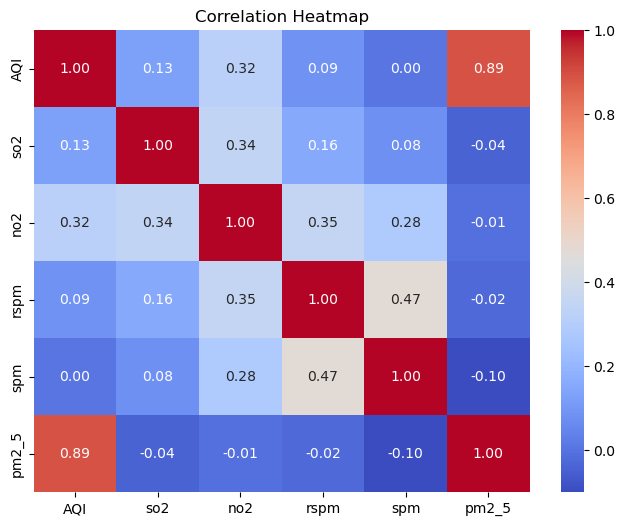

In [12]:
# --- 3. Correlation Between Pollutants ---
corr = df[['AQI', 'so2', 'no2', 'rspm', 'spm', 'pm2_5']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


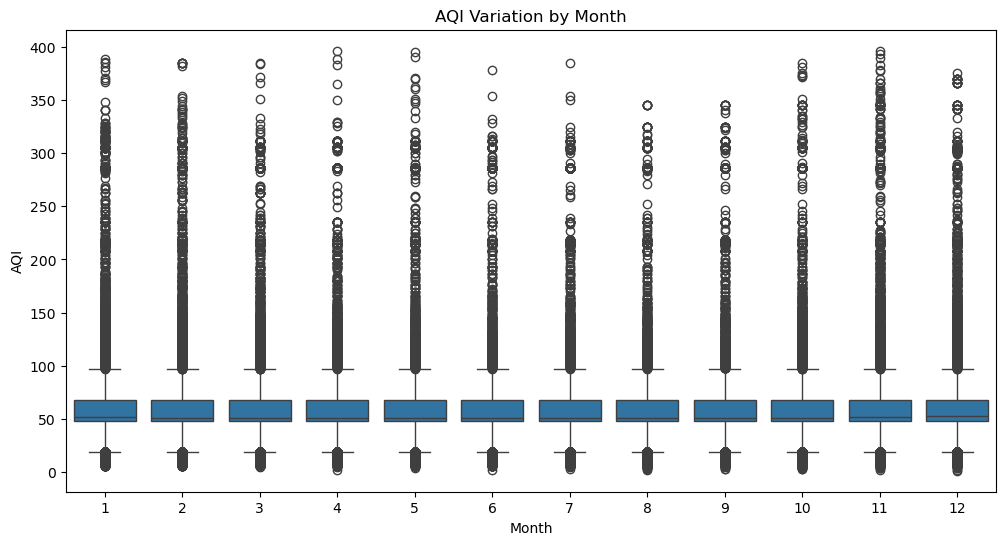

In [13]:
# --- 4. Boxplot of AQI by Month ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='AQI', data=df)
plt.title('AQI Variation by Month')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.show()

In [14]:
# --- 5. Extreme AQI Events ---
threshold = 300  # Define extreme pollution threshold
extreme_events = df[df['AQI'] > threshold]
print("Extreme Pollution Events:")
print(extreme_events[['date', 'location', 'AQI']])

Extreme Pollution Events:
             date   location         AQI
14095  2011-11-22  Hyderabad  345.841176
73673  2015-01-27      Delhi  320.186047
73700  2015-06-08      Delhi  304.837209
73730  2015-10-20      Delhi  326.325581
73731  2015-10-26      Delhi  329.395349
...           ...        ...         ...
435329 2015-01-24    Kolkata  309.441860
435330 2015-01-27    Kolkata  314.046512
435412 2015-11-10    Kolkata  324.790698
435413 2015-11-11    Kolkata  382.348837
435424 2015-12-21    Kolkata  301.000000

[971 rows x 3 columns]


In [15]:
# --- 6. Most Polluted Cities ---
city_avg_aqi = df.groupby('location')['AQI'].mean().sort_values(ascending=False)
print("Most Polluted Cities:")
print(city_avg_aqi.head(10))

Most Polluted Cities:
location
Panaji      286.344828
Panjim      286.344828
Vasco       286.344828
Mormugao    286.344828
MALDAH      218.068966
SILIGURI    218.068966
ULUBERIA    218.068966
DANKUNI     214.655172
Kalyani     214.655172
HALDIA      214.655172
Name: AQI, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_20756\3067812741.py:7: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[pre_diwali['AQI'].dropna(), post_diwali['AQI'].dropna()],


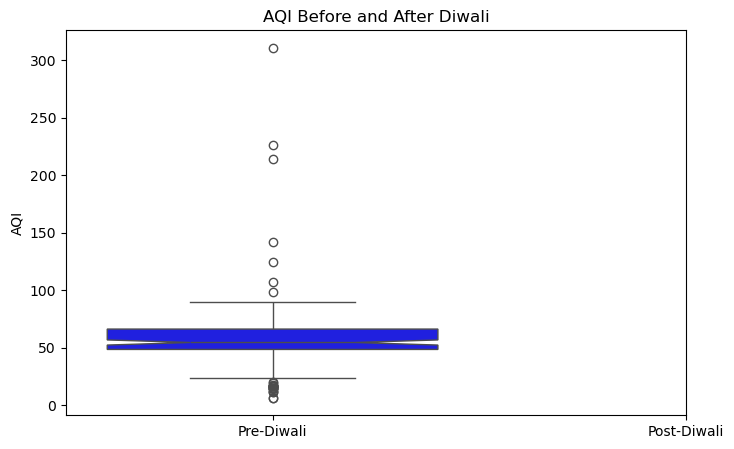

In [18]:
# --- 7. AQI Before and After Diwali (Example) ---
diwali_date = '2014-11-12'  # Replace with actual Diwali date
pre_diwali = df[df['date'] == pd.to_datetime(diwali_date) - pd.Timedelta(days=5)]
post_diwali = df[df['date'] == pd.to_datetime(diwali_date) + pd.Timedelta(days=5)]

plt.figure(figsize=(8, 5))
sns.boxplot(data=[pre_diwali['AQI'].dropna(), post_diwali['AQI'].dropna()],
            notch=True, palette=['blue', 'red'])
plt.xticks([0, 1], ['Pre-Diwali', 'Post-Diwali'])
plt.title('AQI Before and After Diwali')
plt.ylabel('AQI')
plt.show()

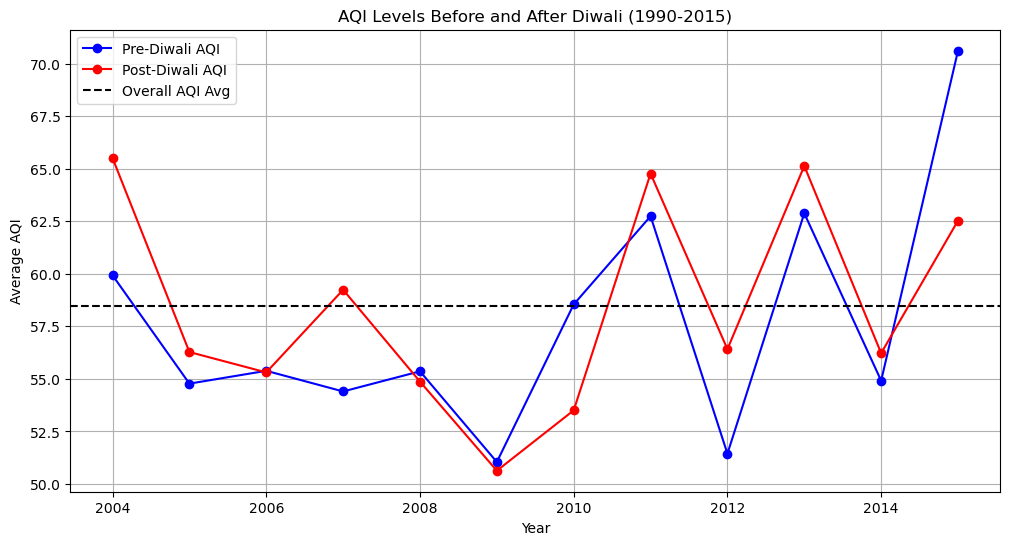

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace with actual Diwali dates from 1990-2015
diwali_dates = {
     2004: '2004-11-12', 2005: '2005-11-01',
    2006: '2006-10-21', 2007: '2007-11-09', 2008: '2008-10-28', 2009: '2009-10-17',
    2010: '2010-11-05', 2011: '2011-10-26', 2012: '2012-11-13', 2013: '2013-11-03',
    2014: '2014-10-23', 2015: '2015-11-11'
}

# Ensure date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Store AQI trends
years = []
pre_diwali_aqi = []
post_diwali_aqi = []

for year, date in diwali_dates.items():
    diwali_date = pd.to_datetime(date)
    
    # Get AQI values 7 days before and after Diwali
    pre_diwali = df[(df['date'] >= diwali_date - pd.Timedelta(days=7)) & (df['date'] < diwali_date)]
    post_diwali = df[(df['date'] > diwali_date) & (df['date'] <= diwali_date + pd.Timedelta(days=5))]
    
    # Append results
    years.append(year)
    pre_diwali_aqi.append(pre_diwali['AQI'].mean())
    post_diwali_aqi.append(post_diwali['AQI'].mean())

# Plot the trends
plt.figure(figsize=(12, 6))
plt.plot(years, pre_diwali_aqi, marker='o', label='Pre-Diwali AQI', color='blue')
plt.plot(years, post_diwali_aqi, marker='o', label='Post-Diwali AQI', color='red')
plt.axhline(y=df['AQI'].mean(), linestyle='dashed', color='black', label='Overall AQI Avg')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Average AQI")
plt.title("AQI Levels Before and After Diwali (1990-2015)")
plt.legend()
plt.grid(True)
plt.show()
